In [1]:
import random
import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime
from transformers import *
import torch
from transformers.data.processors.utils import InputExample
from torch import nn
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm, tnrange 
import time
import bert

2021-12-21 11:13:02.516815: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-21 11:13:02.517381: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2021-12-21 11:13:02.517391: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2021-12-21 11:13:02.517947: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

In [2]:
yelp = pd.read_pickle("./pickled_merged_df.pkl")

In [48]:
number_of_examples = 20000
x = yelp['text'].tolist()[:number_of_examples]
y = yelp['stars'].tolist()[:number_of_examples]

In [49]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [50]:
hidden_size = 100
model = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=hidden_size)
model.classifier.add_module('bert_activation', nn.Tanh())
model.classifier.add_module('prediction', nn.Linear(hidden_size, 5))

In [51]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

FINE_TUNE = True
print(f'Total model trainable parameters {count_parameters(model)}')
if FINE_TUNE:
    for param in model.bert.parameters():
        param.requires_grad = False

    for param in model.classifier.parameters():
        param.requires_grad = True
    print(f'Total head trainable parameters {count_parameters(model)}')
model; #.cuda()


import warnings
warnings.filterwarnings('ignore')

Total model trainable parameters 108387677
Total head trainable parameters 77405


In [52]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
tokenized = tokenizer.tokenize('I am parachuting with you')
print(tokenized)
print(tokenizer.encode(tokenized, add_special_tokens=False))
print(tokenizer.encode(tokenized, add_special_tokens=True))

['I', 'am', 'para', '##chu', '##ting', 'with', 'you']
[146, 1821, 18311, 17143, 1916, 1114, 1128]
[101, 146, 1821, 18311, 17143, 1916, 1114, 1128, 102]


In [53]:
def get_features(df, text_col, label_col, l):
    features = glue_convert_examples_to_features(examples=l, 
                                    tokenizer=tokenizer,
                                    max_length=300,
                                    label_list = df[label_col].values,
                                    output_mode='regression')

    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_attention_mask = torch.tensor([f.attention_mask for f in features], dtype=torch.long)
    all_token_type_ids = torch.tensor([f.token_type_ids for f in features], dtype=torch.long)
    all_labels = torch.tensor([f.label-1 for f in features], dtype=torch.long)
    dataset = TensorDataset(all_input_ids, all_attention_mask, all_labels)
    return dataset

data_train = pd.DataFrame()
data_train['text_clean'] = x_train
data_train['stars'] = y_train

data_test = pd.DataFrame()
data_test['text_clean'] = x_test
data_test['stars'] = y_test


label_col = "stars"
text_col = "text_clean"
l = [InputExample(guid=idx, text_a=data_train.loc[idx, text_col], label=data_train.loc[idx, label_col]) for 
       idx, row in tqdm(data_train.iterrows(), total=data_train.shape[0])]
train_dataset = get_features(yelp, 'text_clean', 'stars', l)

label_col = "stars"
text_col = "text_clean"
l = [InputExample(guid=idx, text_a=data_test.loc[idx, text_col], label=data_test.loc[idx, label_col]) for 
       idx, row in tqdm(data_test.iterrows(), total=data_test.shape[0])]
test_dataset = get_features(yelp, 'text_clean', 'stars', l)

  0%|          | 0/13400 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (691 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (952 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1128 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (558 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (543 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (547 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (562 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (618 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (700 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1331 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (688 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1090 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (559 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (944 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (559 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (579 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (765 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (590 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1012 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (600 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (525 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (730 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1190 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (876 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (748 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (800 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (935 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (562 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (829 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (546 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1185 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (580 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (712 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (593 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (516 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (826 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (628 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (681 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (611 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (831 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (552 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (751 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1204 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (692 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (937 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (905 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1053 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (892 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (881 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (678 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1178 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (518 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (695 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (521 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (721 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1178 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (542 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (588 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (578 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (518 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (736 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1220 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (832 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (523 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (896 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (577 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (952 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (558 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (626 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (789 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (743 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (540 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (587 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (594 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (1188 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (624 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1001 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (823 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1180 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for 

Token indices sequence length is longer than the specified maximum sequence length for this model (1230 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (695 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (674 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (651 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (589 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (555 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (527 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (650 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (646 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (972 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (893 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (773 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (634 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (667 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (519 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (681 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (541 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (853 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (705 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (569 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

  0%|          | 0/6600 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (904 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1350 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1239 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (590 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1237 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for 

Token indices sequence length is longer than the specified maximum sequence length for this model (660 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (542 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (908 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1027 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (558 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (704 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (579 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (749 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (788 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (675 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (581 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1489 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (669 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (585 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (821 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (594 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (534 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (690 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (526 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (722 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (534 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (696 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (522 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1048 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (662 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (542 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (588 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (680 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (560 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (593 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (524 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (777 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (720 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (521 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (870 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (728 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1184 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (712 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (642 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1091 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Token indices sequence length is longer than the specified maximum sequence length for this model (781 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (762 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (551 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (666 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (661 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (802 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (563 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (589 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (991 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (933 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

In [54]:
val_idx, train_idx = train_test_split(np.arange(len(train_dataset)), random_state=4, train_size=0.1)
total_size = len(train_dataset)
val_dataset = TensorDataset(*train_dataset[val_idx])
train_dataset = TensorDataset(*train_dataset[train_idx])
assert total_size == len(val_dataset) + len(train_dataset)

In [55]:
batch_size = 64
gradient_every = 64
assert batch_size <= gradient_every and gradient_every % batch_size == 0

accumulation_steps = gradient_every//batch_size

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size*2, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size*2, shuffle=False)

epochs = 20

lr = 0.002
optimizer = AdamW(model.classifier.parameters(), lr=lr)

tr_losses = []
v_losses = []

In [56]:
model = model.cuda()
for epoch in tnrange(epochs, desc='epoch'):
    """ Training stage """
    epoch_tr_losses = []
    print(f'epoch {epoch+1}')
    for k, (input_ids, attention_mask, labels) in enumerate(tqdm(train_dataloader, total=len(train_dataloader), desc='batch')):
        feed_dict = {'input_ids': input_ids.cuda(), #.cuda()
                     'attention_mask': attention_mask.cuda(), #.cuda()
                     'labels': labels.cuda()} #.cuda()
        
        loss, _ = model(**feed_dict)

        # gradient accumulation
        epoch_tr_losses.append(loss.item())
        loss = loss/accumulation_steps
        loss.backward()
        if (k + 1) % accumulation_steps == 0:
            optimizer.step()
            model.zero_grad()

    tr_losses.append(np.mean(epoch_tr_losses))
    print(f'train NLL loss: {np.mean(epoch_tr_losses)}')
  
    """ Validation stage """
    epoch_v_losses = [] 
    with torch.no_grad():
        for k, (input_ids, attention_mask, labels) in enumerate(tqdm(val_dataloader, total=len(val_dataloader), desc='val batch')):
            feed_dict = {'input_ids': input_ids.cuda(), #.cuda()
                         'attention_mask': attention_mask.cuda(), #.cuda()
                         'labels': labels.cuda()}  #.cuda()

            loss, pred = model(**feed_dict)
            epoch_v_losses.append(loss.item())
        v_losses.append(np.mean(epoch_v_losses))
    print(f'validation BCE loss: {np.mean(epoch_v_losses)}')
    #torch.save(model.classifier.state_dict(), f'/kaggle/working/yelp-head{epoch}.pt')
    torch.save(model, 'test_checkpoint.pth')

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 1


batch:   0%|          | 0/189 [00:00<?, ?it/s]

train NLL loss: 1.4325859735882471


val batch:   0%|          | 0/11 [00:00<?, ?it/s]

validation BCE loss: 1.3766204118728638
epoch 2


batch:   0%|          | 0/189 [00:00<?, ?it/s]

train NLL loss: 1.3273115782510667


val batch:   0%|          | 0/11 [00:00<?, ?it/s]

validation BCE loss: 1.3001055283979936
epoch 3


batch:   0%|          | 0/189 [00:00<?, ?it/s]

train NLL loss: 1.2928562624744637


val batch:   0%|          | 0/11 [00:00<?, ?it/s]

validation BCE loss: 1.275824698534879
epoch 4


batch:   0%|          | 0/189 [00:00<?, ?it/s]

train NLL loss: 1.2745860524909207


val batch:   0%|          | 0/11 [00:00<?, ?it/s]

validation BCE loss: 1.2720414833589033
epoch 5


batch:   0%|          | 0/189 [00:00<?, ?it/s]

train NLL loss: 1.261358004398447


val batch:   0%|          | 0/11 [00:00<?, ?it/s]

validation BCE loss: 1.3596108068119397
epoch 6


batch:   0%|          | 0/189 [00:00<?, ?it/s]

train NLL loss: 1.2556247622878463


val batch:   0%|          | 0/11 [00:00<?, ?it/s]

validation BCE loss: 1.2537406141107732
epoch 7


batch:   0%|          | 0/189 [00:00<?, ?it/s]

train NLL loss: 1.2447646704931108


val batch:   0%|          | 0/11 [00:00<?, ?it/s]

validation BCE loss: 1.2549492012370715
epoch 8


batch:   0%|          | 0/189 [00:00<?, ?it/s]

train NLL loss: 1.2382743491066828


val batch:   0%|          | 0/11 [00:00<?, ?it/s]

validation BCE loss: 1.2803472388874402
epoch 9


batch:   0%|          | 0/189 [00:00<?, ?it/s]

train NLL loss: 1.2206081981381411


val batch:   0%|          | 0/11 [00:00<?, ?it/s]

validation BCE loss: 1.2938840172507546
epoch 10


batch:   0%|          | 0/189 [00:00<?, ?it/s]

train NLL loss: 1.2256677765694877


val batch:   0%|          | 0/11 [00:00<?, ?it/s]

validation BCE loss: 1.2434918772090564
epoch 11


batch:   0%|          | 0/189 [00:00<?, ?it/s]

train NLL loss: 1.215111359086617


val batch:   0%|          | 0/11 [00:00<?, ?it/s]

validation BCE loss: 1.2376562465320935
epoch 12


batch:   0%|          | 0/189 [00:00<?, ?it/s]

train NLL loss: 1.2216857173455455


val batch:   0%|          | 0/11 [00:00<?, ?it/s]

validation BCE loss: 1.2256290045651523
epoch 13


batch:   0%|          | 0/189 [00:00<?, ?it/s]

train NLL loss: 1.215200545611205


val batch:   0%|          | 0/11 [00:00<?, ?it/s]

validation BCE loss: 1.272543733770197
epoch 14


batch:   0%|          | 0/189 [00:00<?, ?it/s]

train NLL loss: 1.2123889254514502


val batch:   0%|          | 0/11 [00:00<?, ?it/s]

validation BCE loss: 1.243406523357738
epoch 15


batch:   0%|          | 0/189 [00:00<?, ?it/s]

train NLL loss: 1.2034375424738284


val batch:   0%|          | 0/11 [00:00<?, ?it/s]

validation BCE loss: 1.2257951931519941
epoch 16


batch:   0%|          | 0/189 [00:00<?, ?it/s]

train NLL loss: 1.2059933306678894


val batch:   0%|          | 0/11 [00:00<?, ?it/s]

validation BCE loss: 1.274349494413896
epoch 17


batch:   0%|          | 0/189 [00:00<?, ?it/s]

train NLL loss: 1.2238919463737932


val batch:   0%|          | 0/11 [00:00<?, ?it/s]

validation BCE loss: 1.2243021293119951
epoch 18


batch:   0%|          | 0/189 [00:00<?, ?it/s]

train NLL loss: 1.1965099746588046


val batch:   0%|          | 0/11 [00:00<?, ?it/s]

validation BCE loss: 1.389309753071178
epoch 19


batch:   0%|          | 0/189 [00:00<?, ?it/s]

train NLL loss: 1.2086885593555592


val batch:   0%|          | 0/11 [00:00<?, ?it/s]

validation BCE loss: 1.247246427969499
epoch 20


batch:   0%|          | 0/189 [00:00<?, ?it/s]

train NLL loss: 1.1987888693178772


val batch:   0%|          | 0/11 [00:00<?, ?it/s]

validation BCE loss: 1.2557843164964155


In [59]:
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt

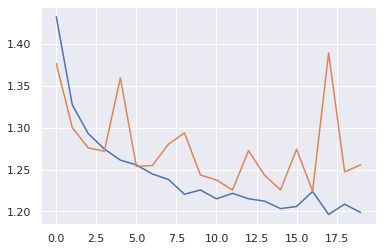

In [60]:
plt.plot(tr_losses)
plt.plot(v_losses)

In [25]:
batch_predictions, batch_actual = [], []
with torch.no_grad():
    for k, (input_ids, attention_mask, labels) in enumerate(tqdm(test_dataloader, total=len(test_dataloader), desc='val batch')):
        feed_dict = {'input_ids': input_ids.cuda(),
                     'attention_mask': attention_mask.cuda()} 
        
        pred = model(**feed_dict)[0].cpu()
        batch_predictions.append(pred.numpy())
        batch_actual.append(labels)
        
        if k % 10 == 0:
            predictions = np.array([i for k in batch_predictions for i in k ])

            predictions = np.argmax(predictions, axis=1)
            actual = np.array([i for k in batch_actual for i in k ])

            print("f1 for exact score at iteration %s, " % k, f1_score(actual, predictions, average='micro'))

val batch:   0%|          | 0/2579 [00:00<?, ?it/s]

f1 at iteration 0,  0.53125
f1 at iteration 10,  0.4758522727272727
f1 at iteration 20,  0.46130952380952384
f1 at iteration 30,  0.4632056451612903
f1 at iteration 40,  0.47027439024390244
f1 at iteration 50,  0.4632352941176471
f1 at iteration 60,  0.45927254098360654
f1 at iteration 70,  0.4647887323943662
f1 at iteration 80,  0.4664351851851852
f1 at iteration 90,  0.46668956043956045
f1 at iteration 100,  0.46782178217821785
f1 at iteration 110,  0.46734234234234234
f1 at iteration 120,  0.4673295454545454
f1 at iteration 130,  0.4666030534351145
f1 at iteration 140,  0.46875
f1 at iteration 150,  0.46947433774834435
f1 at iteration 160,  0.46952639751552794
f1 at iteration 170,  0.46710526315789475
f1 at iteration 180,  0.46780041436464087
f1 at iteration 190,  0.46637761780104714
f1 at iteration 200,  0.4646299751243781
f1 at iteration 210,  0.4649733412322275
f1 at iteration 220,  0.46330599547511314
f1 at iteration 230,  0.4650297619047619
f1 at iteration 240,  0.4627852697095

f1 at iteration 1970,  0.4650161719939117
f1 at iteration 1980,  0.46511389449772844
f1 at iteration 1990,  0.46507722250125566
f1 at iteration 2000,  0.46499406546726635
f1 at iteration 2010,  0.4650127424167081
f1 at iteration 2020,  0.4651549356754082
f1 at iteration 2030,  0.46508031757754803
f1 at iteration 2040,  0.4650064306712396
f1 at iteration 2050,  0.46504753778644564
f1 at iteration 2060,  0.4650351770984959
f1 at iteration 2070,  0.46503048044422984
f1 at iteration 2080,  0.4650783877943296
f1 at iteration 2090,  0.4652155069344811
f1 at iteration 2100,  0.46529926225606855
f1 at iteration 2110,  0.4653748223590715
f1 at iteration 2120,  0.4652728665723715
f1 at iteration 2130,  0.46510587752229
f1 at iteration 2140,  0.4650718122372723
f1 at iteration 2150,  0.46512523245002324
f1 at iteration 2160,  0.4650986233225359
f1 at iteration 2170,  0.4652737793643482
f1 at iteration 2180,  0.4653971801925722
f1 at iteration 2190,  0.46541248288452763
f1 at iteration 2200,  0.46

In [26]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

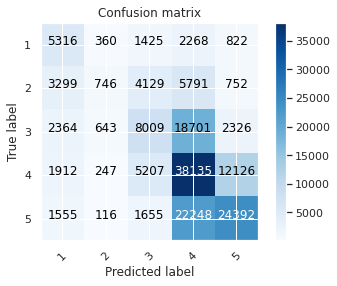

In [27]:
from sklearn.metrics import confusion_matrix
import itertools
confusion_mtx = confusion_matrix(actual, predictions) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(1,6))
plt.show()